In [1]:
# lib imports
# def import_or_install(package, import_as=None):
#     try:
#         if import_as:
#             globals()[import_as] = __import__(package)
#             print(f"Imported: {package} as {import_as}")
#         else:
#             globals()[package] = __import__(package)
#             print(f"Imported: {package}")
#     except ImportError:
#         print(f"{package} is not installed. Installing now...")
#         !pip install {package}
#         if import_as:
#             globals()[import_as] = __import__(package)
#         else:
#             globals()[package] = __import__(package)
#         print(f"{package} has been installed and imported.")


# # import libs
# import_or_install('yfinance', 'yf')
# import_or_install('pandas', 'pd')
# import_or_install('xgboost', 'xgb')
# import_or_install('matplotlib')
# import_or_install('sklearn')
import yfinance as yf
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
# !pip install scikit-optimize
# from skopt import gp_minimize
# from skopt.space import Real, Integer
# from skopt.utils import use_named_args
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import multiprocessing
from copy import copy, deepcopy
from typing import List, Any, Callable
import time
import pickle as pkl
import os
import sys
from datetime import datetime, timedelta
from yfinance import shared
%matplotlib inline

def format_time_difference(start_time, end_time):
    time_difference = end_time - start_time

    # Calculate hours, minutes, and seconds
    hours, remainder = divmod(time_difference, 3600)
    minutes, seconds = divmod(remainder, 60)

    return f"hours: {int(hours)}, minutes: {int(minutes)}, seconds: {int(seconds)}"


def create_dataset(data: List, window_size: int) -> tuple[np.ndarray, np.ndarray]:
    input, target = [], []
    for i in range(len(data) - window_size):
        input.append(data[i:i+window_size])
        target.append(data[i+window_size])
    return np.array(input), np.array(target)


def create_datasets(ticker_data, dataset_dict={}, train_test_split=0.8, window_range=(5,100)) -> dict:
    train_size = int(len(ticker_data) * train_test_split)
    train_data = ticker_data[:train_size]
    test_data = ticker_data[train_size:]
    if len(window_range) == 2:
        start, stop = window_range
        step = 1
    else:
        start, stop, step = window_range
    stop += 1

    for window_size in range(start, stop, step):
        x_test, y_test = create_dataset(test_data, window_size)
        x_train, y_train = create_dataset(train_data, window_size)
        dataset_dict[window_size] = {
            'x_test': x_test,
            'y_test': y_test,
            'x_train': x_train,
            'y_train': y_train
        }
    return dataset_dict


def create_plot(test, pred, ticker_name, plt_size_x=10, plt_size_y=6, c_test='b', c_pred='r-', linewidth_test=2, linewidth_pred=0.75, title=''):
    plt.figure(figsize=(plt_size_x, plt_size_y))
    plt.plot(np.arange(len(test)), test, c_test, label="Actual", linewidth=linewidth_test)
    plt.plot(np.arange(len(pred)), pred, c_pred, label="Prediction", linewidth=linewidth_pred)
    if title == '':
        title = f"{ticker_name} Price Prediction"
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.savefig('prediction_plot.pdf', format='pdf')
    plt.show()


class Creature():
    def __init__(self, param_space: dict, mutable_params: list, objective: Callable, data_dict: dict, params={}) -> None:
        self._params = params
        self._param_space = param_space
        self._mutable_params = mutable_params
        self._objective = objective
        self._data_dict = data_dict
        self._score = None

    @property
    def params(self) -> dict:
        return self._params

    @params.setter
    def params(self, params) -> None:
        self._params = params

    @property
    def score(self) -> None | float:
        return self._score

    @score.setter
    def score(self, score) -> None:
        self._score = score

    @property
    def fitness(self) -> float:
        if self._score is None:
            if len(self._params) == 0:
                self.generate()
            self._score = self._objective(self._params, self._data_dict[self._params['window_size']])
        return 1/self._score

    def mutate(self, stats_dict=None, inplace=True, mutation_chance=0.1, rand_param=False) -> dict:
        mutated_params = self._params.copy() if not inplace else self._params   # create a copy of params dictionary or copy a reference
        for key in self._mutable_params:
            if random.random() < mutation_chance:
                floor, ceil, step = self._param_space[key]
                if rand_param:  # set random value from range defined in param_space
                    new_value = random.uniform(floor, ceil)
                    new_value = round((new_value - floor) / step) * step + floor
                else:   # increment or decrement current value by one step
                    new_value = mutated_params[key] + step * random.choice([-1, 1])
                    new_value = min(ceil, new_value)    # keep new value in range
                    new_value = max(floor, new_value)   # keep new value in range
                mutated_params[key] = new_value
                if stats_dict:
                    stats_dict['mutations'] = stats_dict['mutations'] + 1
        return mutated_params

    def generate(self) -> None:
        self._params = {}
        for param_name, (floor, ceil, step) in self._param_space.items():
            new_value = random.uniform(floor, ceil)
            new_value = round((new_value - floor) / step) * step + floor
            self._params[param_name] = new_value

    def __str__(self) -> str:
        return str(self._params) + '\n' + f'Mae: {self._score}'

    def reset_score(self) -> None:
        self._score = None

    def get_copy(self) -> 'Creature':
        new_creature = copy(self)
        new_creature.params = deepcopy(self._params)
        new_creature.reset_score()
        return new_creature

    def get_params_hash(self) -> float:
        return hash(self._params.values())


def get_fitness_wrapper(creature) -> float:
    return creature.fitness


def roulette_selection(creatures:List[Creature], num_creatures:int) -> List[Creature]:
    probs: np.ndarray = np.array(list(x.fitness for x in creatures))
    probs = np.power(probs, 3)  # use power to make differences in model performance more apparent
    probs = probs / np.sum(probs)   # scale probs such that the sum is 1
    return list(np.random.choice(np.array(creatures), num_creatures, replace=False, p=probs))


def tournament_selection(creatures:List[Creature], tournament_size:int) -> List[Creature]:
    return creatures[:tournament_size]


def one_point_crossover(c_1: Creature, c_2: Creature) -> tuple[Creature, Creature]:
    keys = list(c_1.params.keys())
    random.shuffle(keys)
    cross_point = len(keys) // 2
    keyset_1, keyset_2 = keys[cross_point:], keys[:cross_point]
    c_3, c_4 = c_1.get_copy(), c_2.get_copy()
    for key in keyset_1:
        c_3.params[key], c_4.params[key] = c_1.params[key], c_2.params[key]
    for key in keyset_2:
        c_3.params[key], c_4.params[key] = c_2.params[key], c_1.params[key]
    return c_3, c_4


class GeneticLearner():
    def __init__(self, *args, **kwargs) -> None:
        self._selection_funcs = {
            'tournament': tournament_selection,
            'roulette': roulette_selection
        }
        self._crossover_funcs = {
            'one_point': one_point_crossover
        }
        self._creatures: List[Creature] = []
        self._new_generation: List[Creature] = []
        self._best_creature = None

        self._defaults = {
            'num_rounds': 100,
            'num_creatures': 100,
            'preserve_num': 10,
            'mutation_chance': 0.1,
            'mutable_params': None,
            'param_space': None,
            'objective_func': None,
            'random_mutate': False

        }
        self._stats = {
            'creatures_tested': 0,
            'total_time': 0,
            'mutations': 0
        }
        self._score_dict: dict = {} # we cache creatures by score, as it is the output of objective function

        self._defaults['selection_func'] = next(iter(self._selection_funcs.items()))[1]
        self._defaults['crossover_func'] = next(iter(self._crossover_funcs.items()))[1]
        self._attrs = dict(self._defaults)

        try:
            self._attrs.update(zip(self._attrs, args))
            self._attrs.update(kwargs)
        except KeyError as e:
            print("KeyError:", e)
            exit()

        if not self._attrs['objective_func']:
            raise ValueError("Objective function is required.")

        if self._attrs['mutation_chance'] <= 0 or self._attrs['mutation_chance'] > 1:
            raise ValueError("Invalid value for mutation_chance. Must be in range 0-1.")

        if not isinstance(self._attrs['mutation_chance'], float):
            raise ValueError("Invalid type for mutation_chance. Must be of type float.")

        if not isinstance(self._attrs['num_rounds'], int):
            raise ValueError("Invalid type for num_rounds. Must be of type int.")

        if not isinstance(self._attrs['num_creatures'], int):
            raise ValueError("Invalid type for num_creatures. Must be of type int.")

        if not isinstance(self._attrs['preserve_num'], int):
            raise ValueError("Invalid type for preserve_num. Must be of type int.")

        if not isinstance(self._attrs['selection_func'], Callable):
            raise ValueError("Invalid type for selection_func. Must be a function.")

        if not isinstance(self._attrs['crossover_func'], Callable):
            raise ValueError("Invalid type for crossover_func. Must be a function.")

        if not isinstance(self._attrs['mutable_params'], list) and self._attrs['mutable_params'] is not None:
            raise ValueError("Invalid type for mutable_params. Must be a list or None.")

        if not isinstance(self._attrs['param_space'], dict) and self._attrs['mutable_params'] is not None:
            raise ValueError("Invalid type for mutable_params. Must be a dict or None.")

    def learn(self, data) -> Creature | None:
        # jump start population
        if len(self._creatures) == 0:
            self._populate(data)

        # train for set number of rounds
        for round_num in range(self._attrs['num_rounds']):
            tic = time.time()
            print(f'Training generation {round_num}')

            # train and sort by fitness
            self._population_eval()

            # add creatures to fitness dict
            for creature in self._creatures:
                self._score_dict[creature.get_params_hash()] = creature.score

            # print best at the beginning of training
            if self._best_creature is None:
                print(f"Best: {str(self._creatures[0])}\n")
                self._best_creature = self._creatures[0]
            # print update about new best only if it has changed
            elif self._best_creature.params != self._creatures[0].params:
                print(f"Found new best: {str(self._creatures[0])}")
                self._best_creature = self._creatures[0]

            # update the population
            self._create_new_generation(data)

            # print training time for this generation
            toc = time.time()
            print(f'Time taken: {format_time_difference(tic, toc)}')
            print()
        return self._best_creature

    def _population_eval(self) -> None:
        # get score for each creature and sort according to fitness (models are trained jit)
        self._creatures.sort(key=lambda x: x.fitness, reverse=True)

    def _population_eval_mt(self):  # doesnt work for now
        cpu_count = multiprocessing.cpu_count()
        print(f"Cpu count: {cpu_count}")
        if cpu_count > 16:
            cpu_count = 16
            print('Limiting cpu count to 16')
        pool = multiprocessing.Pool(processes=cpu_count)
        pool.map(get_fitness_wrapper, self._creatures)
        pool.close()
        pool.join()
        self._creatures.sort(key=lambda x: x.fitness, reverse=True)

    def _populate(self, data) -> None:
        # fill population with randomly generated creatures
        self._creatures = [
            Creature(self._attrs['param_space'], self._attrs['mutable_params'], self._attrs['objective_func'], data) for _ in range(self._attrs['num_creatures'])
        ]

    def _create_new_generation_old(self, data) -> None:
        # choose set number of best creatures according to selection function
        self._new_generation.extend(self._attrs['selection_func'](self._creatures, self._attrs['preserve_num']))
        # shuffle for random breeding
        random.shuffle(self._new_generation)
        # make new creatures
        for i in range(0, len(self._new_generation), 2):
            self._new_generation.extend(self._attrs['crossover_func'](*self._new_generation[i:i+2]))
        # fill the remaining space in the population with random creatures
        for _ in range(self._attrs['num_creatures'] - len(self._new_generation)):
            new_creature = self._new_generation[0].get_copy()
            new_creature.generate()
            self._new_generation.append(new_creature)
        # set new population as base, reset new
        self._creatures, self._new_generation = self._new_generation, []

    def _create_new_generation(self, data) -> None:
        # choose set number of best creatures according to selection function
        parents = self._attrs['selection_func'](self._creatures, self._attrs['preserve_num'])
        # shuffle for random breeding
        random.shuffle(parents)
        # preserve best creature
        self._new_generation.append(self._creatures[0])
        # create mutated copy
        mutated_best = self._creatures[0].get_copy()
        # attempt to mutate a creature until it is unique and has not been tested before
        for mutation_attempt in range(100):
            mutated_best.mutate()
            if not(mutated_best.params == self._creatures[0].params or mutated_best.get_params_hash() in self._score_dict):
                break
        self._new_generation.append(mutated_best)

        # make new creatures
        for i in range(0, len(parents), 2):
            children: List[Creature] = self._attrs['crossover_func'](*self._creatures[i:i+2])
            # mutate children
            for child in children:
                child.mutate(rand_param=self._attrs['random_mutate'])
                # if a child happens to have been tested before, reasign the score to avoid retraining
                if child.get_params_hash() in self._score_dict:
                    child.score = self._score_dict[child.get_params_hash()]
            self._new_generation.extend(children)

        # fill the remaining space in the population with random creatures
        for _ in range(self._attrs['num_creatures'] - len(self._new_generation)):
            # create a random creature by regenerating a copy of existing one
            new_creature = self._new_generation[0].get_copy()
            new_creature.generate()
            # if a creature happens to have been tested before, reasign the score to avoid retraining
            if new_creature.get_params_hash() in self._score_dict:
                new_creature.score = self._score_dict[new_creature.get_params_hash()]
            self._new_generation.append(new_creature)
        # set new population as base, reset new
        self._creatures, self._new_generation = self._new_generation, []


def objective_function(params: dict, dataset_dict: dict, verbose=False) -> float:
    xgbreg_params = {
        'objective': 'reg:squarederror',
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators']
    }
    model = xgb.XGBRegressor(**xgbreg_params)
    model.fit(dataset_dict['x_train'], dataset_dict['y_train'], verbose=verbose)
    y_pred = model.predict(dataset_dict['x_test'])
    return mean_absolute_error(dataset_dict['y_test'], y_pred)


def create_data_dict(ticker_name, interval, window_size) -> dict:
    print(f"Creating dataset for {ticker_name}, interval: {interval}, window_size: {window_size}.")
    # Get today's date
    today = datetime.now().date()

    # Calculate start and end dates, download data (yfinance allows at max 730 days from current date)
    start = today - timedelta(days=729)
    end = today - timedelta(days=1)
    while True:
        data = yf.download(f'{ticker_name}=X', start=start, end=end, interval=interval)['Close']
        if data is not None and len(data) > 0:
            break
        error_message = shared._ERRORS[f'{ticker_name}=X']
        if error_message is not None:
            split_string = error_message.split()
            split_string.reverse()
            for item in split_string:
                if item.isdigit():
                    start = today - timedelta(days=int(item) -1)

    print(f'Downloaded {len(data)} tickers for {ticker_name}.')

    # Create dataset dictionary
    data_dict = create_datasets(data, window_range=window_size)
    data_dict['start'] = start
    data_dict['end'] = end
    data_dict['interval'] = interval
    data_dict['num_tickers'] = len(data)
    data_dict['window_size'] = window_size


    # save data dict for later use
    with open(f'{ticker_name}_{interval}.pickle', 'wb') as file:
        pkl.dump(data_dict, file)
        print(f"Saved dataset for {ticker_name} from {data_dict['start']} to {data_dict['end']}, interval: {interval}.")
    return data_dict

def load_data_dict(ticker_name, interval, window_size) -> dict:
    with open(f'{ticker_name}_{interval}.pickle', 'rb') as file:
        data_dict = pkl.load(file)
    if data_dict['window_size'] != window_size:
        print("Window sizes don't match. Creating new dataset.")
        data_dict = create_data_dict(ticker_name, interval, window_size)
    print(f"Loaded dataset for {ticker_name} from {data_dict['start']} to {data_dict['end']}, interval: {interval}.")
    return data_dict

Loaded dataset for EURUSD from 2022-04-07 to 2024-04-04, interval: 1h.
Training generation 0
Best: {'max_depth': 5, 'learning_rate': 0.09999999999999999, 'n_estimators': 460, 'window_size': 120}
Mae: 0.0006185548261867375

Time taken: hours: 0, minutes: 0, seconds: 26

Training generation 1
Found new best: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 230, 'window_size': 150}
Mae: 0.0006086177073351624
Time taken: hours: 0, minutes: 0, seconds: 14

Training generation 2
Time taken: hours: 0, minutes: 0, seconds: 0

Training generation 3
Time taken: hours: 0, minutes: 0, seconds: 0

Training generation 4
Time taken: hours: 0, minutes: 0, seconds: 1

Training generation 5
Time taken: hours: 0, minutes: 0, seconds: 0

Training generation 6
Time taken: hours: 0, minutes: 0, seconds: 0

Training generation 7
Time taken: hours: 0, minutes: 0, seconds: 0

Training generation 8
Time taken: hours: 0, minutes: 0, seconds: 0

Training generation 9
Time taken: hours: 0, minutes: 0, secon

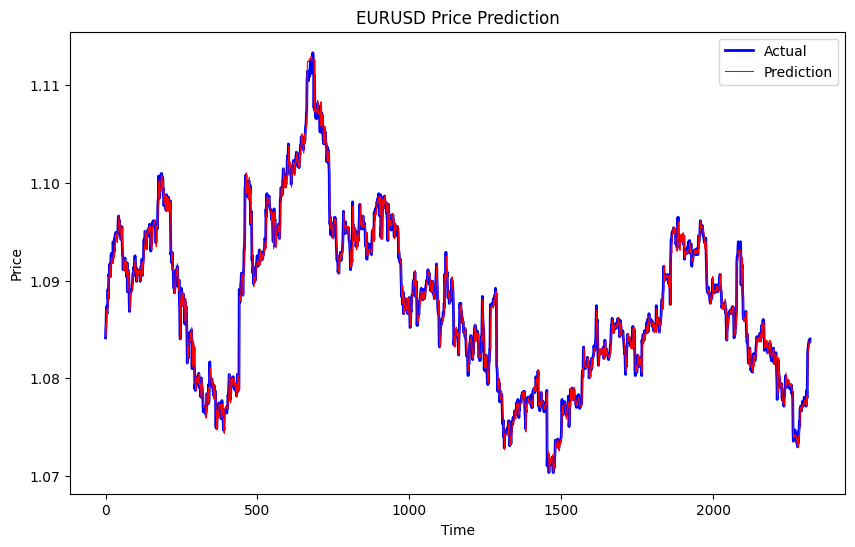

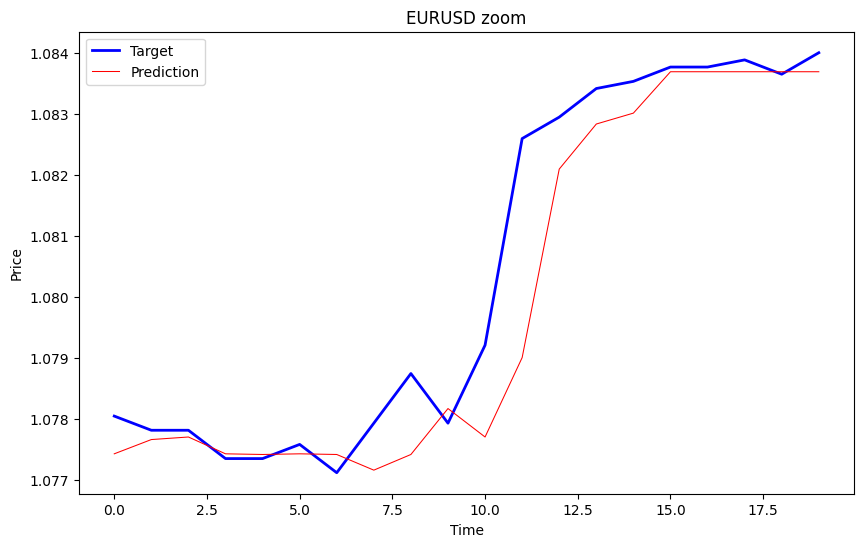

Mean Absolute Error: 0.0006086177073351624
Mean Squared Error: 8.246659625592421e-07
R-squared score: 0.9879682875757385


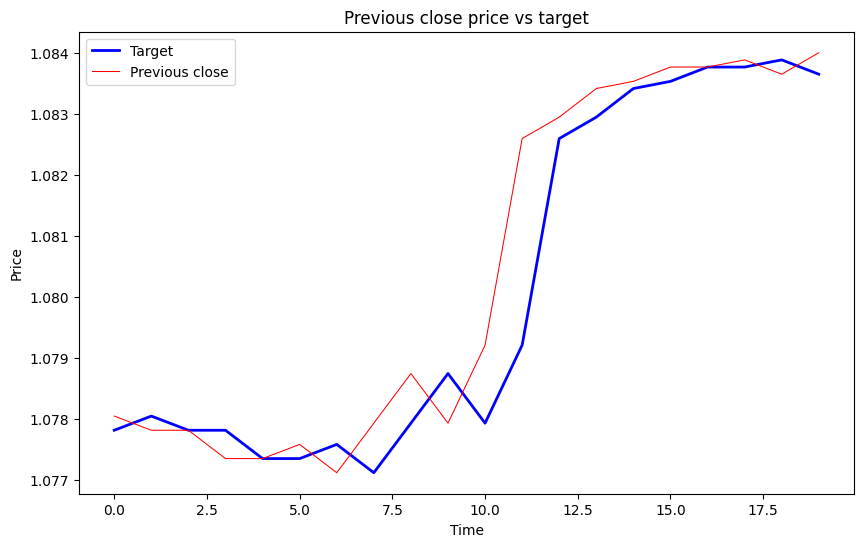

Mean Absolute Error: 0.0005532998162747047
Mean Squared Error: 7.365874120434068e-07
R-squared score: 0.9892527691765202


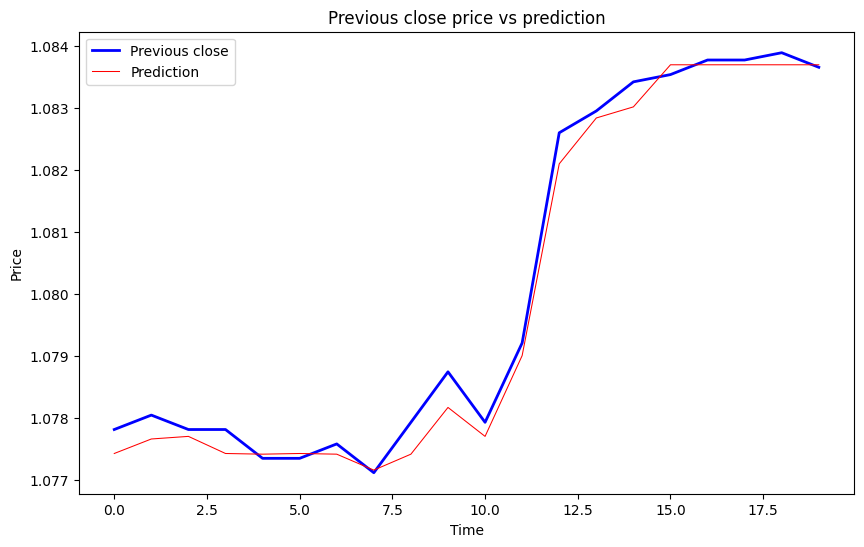

Mean Absolute Error: 0.0001961390691463574
Mean Squared Error: 7.663778069708847e-08
R-squared score: 0.9988818110308647


In [2]:
ticker_name = 'EURUSD'
interval='1h'
space = {
    'max_depth': (1, 10, 1),
    'learning_rate': (0.01, 0.3, 0.01),
    'n_estimators': (100, 2000, 10),
    'window_size': (5, 400, 5)
}
mutable_params = ['max_depth', 'learning_rate', 'n_estimators', 'window_size']


if os.path.exists(f'{ticker_name}_{interval}.pickle'):
    data_dict = load_data_dict(ticker_name, interval, space['window_size'])
else:
    data_dict = create_data_dict(ticker_name, interval, space['window_size'])

learner = GeneticLearner(num_rounds=10, num_creatures=20, preserve_num=8, mutable_params=mutable_params, objective_func=objective_function, param_space=space, selection_func=roulette_selection, random_mutate=True)
best = learner.learn(data_dict)

############################# testy
# scores = []
# for creature in learner._creatures:
#     scores.append(creature.fitness)
# print(scores)

# xtest, ytest = data_dict[5]['x_test'], data_dict[5]['y_test']
# print(len(xtest))
# print(len(ytest))
# print()
# for i in range(10):
#     print(f"{xtest[i]}     {ytest[i]}")

# best = Creature({}, [], objective_function, data_dict, {'max_depth': 4, 'learning_rate': 0.060000000000000005, 'n_estimators': 920, 'window_size': 160})
#######################



if best is None:    # exit if there is no model to retrain
    print('Training has failed')
    sys.exit()

# retrain the model using best params from search
xgbreg_params = {
        'objective': 'reg:squarederror',
        'max_depth': best.params['max_depth'],
        'learning_rate': best.params['learning_rate'],
        'n_estimators': best.params['n_estimators']
    }
model = xgb.XGBRegressor(**xgbreg_params)
model.fit(data_dict[best.params['window_size']]['x_train'], data_dict[best.params['window_size']]['y_train'], verbose=False)
y_pred = model.predict(data_dict[best.params['window_size']]['x_test'])

# plot prediction and test data
create_plot(data_dict[best.params['window_size']]['y_test'], y_pred, 'EURUSD')
# create zoom plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data_dict[best.params['window_size']]['y_test'][-20:])), data_dict[best.params['window_size']]['y_test'][-20:], 'b', label="Target", linewidth=2)
plt.plot(np.arange(len(y_pred[-20:])), y_pred[-20:], 'r-', label="Prediction", linewidth=0.75)
plt.title(f"EURUSD zoom")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# calculate error values
mae = mean_absolute_error(data_dict[best.params['window_size']]['y_test'], y_pred)
mse = mean_squared_error(data_dict[best.params['window_size']]['y_test'], y_pred)
r2 = r2_score(data_dict[best.params['window_size']]['y_test'], y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared score:", r2)



# cena zamknięcia jako symulowany output modelu
prev_close = [x[-1] for x in data_dict[best.params['window_size']]['x_test']]

# plot ceny zamknięcia vs targetu (następna cena, to co chcemy przewidywać)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(prev_close[-20:])), prev_close[-20:], 'b', label="Target", linewidth=2)
plt.plot(np.arange(len(data_dict[best.params['window_size']]['y_test'][-20:])), data_dict[best.params['window_size']]['y_test'][-20:], 'r-', label="Previous close", linewidth=0.75)
plt.title(f"Previous close price vs target")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
# errory
mae = mean_absolute_error(prev_close, data_dict[best.params['window_size']]['y_test'])
mse = mean_squared_error(prev_close, data_dict[best.params['window_size']]['y_test'])
r2 = r2_score(prev_close, data_dict[best.params['window_size']]['y_test'])
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared score:", r2)


# plot cena zamknięcia vs faktyczna predykcja
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(prev_close[-20:])), prev_close[-20:], 'b', label="Previous close", linewidth=2)
plt.plot(np.arange(len(y_pred[-20:])), y_pred[-20:], 'r-', label="Prediction", linewidth=0.75)
plt.title(f"Previous close price vs prediction")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
# errory
mae = mean_absolute_error(prev_close, y_pred)
mse = mean_squared_error(prev_close, y_pred)
r2 = r2_score(prev_close, y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared score:", r2)

In [ ]:
# podawanie poprzedniej ceny daje mae ok 0.00057

# Best: {'max_depth': 3, 'learning_rate': 0.02, 'n_estimators': 660, 'window_size': 30}
# Mae: 0.0006717796642255981

# Best: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 1010, 'window_size': 160}
# Mae: 0.0006157858333529823

# Best: {'max_depth': 4, 'learning_rate': 0.060000000000000005, 'n_estimators': 920, 'window_size': 160}
# Mae: 0.0006141577927567527

# Best: {'max_depth': 4, 'learning_rate': 0.04, 'n_estimators': 1240, 'window_size': 95}
# Mae: 0.0006049690170255948

Creating dataset for EURUSD, interval: 5m, window_size: (5, 200, 5).


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['EURUSD=X']: Exception('%ticker%: 5m data not available for startTime=1649286000 and endTime=1712185200. The requested range must be within the last 60 days.')
[*********************100%%**********************]  1 of 1 completed
C:\Users\janic\AppData\Local\Temp\ipykernel_4052\167148972.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target.append(data[i+window_size])


Downloaded 11927 tickers for EURUSD.
Saved dataset for EURUSD from 2024-02-06 to 2024-04-04, interval: 5m.
Training generation 0
Best: {'max_depth': 10, 'learning_rate': 0.19, 'n_estimators': 1440, 'window_size': 40}
Mae: 0.0001293186539782486

Time taken: hours: 0, minutes: 0, seconds: 6

Training generation 1
Found new best: {'max_depth': 10, 'learning_rate': 0.18, 'n_estimators': 1440, 'window_size': 40}
Mae: 0.0001292312541581176
Time taken: hours: 0, minutes: 0, seconds: 4

Training generation 2
Time taken: hours: 0, minutes: 0, seconds: 3

Training generation 3
Found new best: {'max_depth': 10, 'learning_rate': 0.18, 'n_estimators': 1440, 'window_size': 35}
Mae: 0.00012851811023227005
Time taken: hours: 0, minutes: 0, seconds: 4

Training generation 4
Time taken: hours: 0, minutes: 0, seconds: 0

Training generation 5
Time taken: hours: 0, minutes: 0, seconds: 3

Training generation 6
Time taken: hours: 0, minutes: 0, seconds: 4

Training generation 7
Time taken: hours: 0, minute

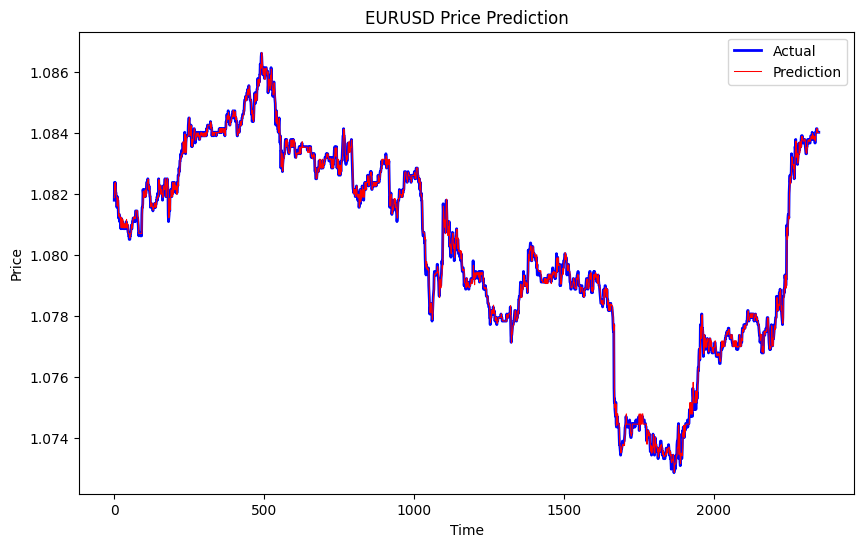

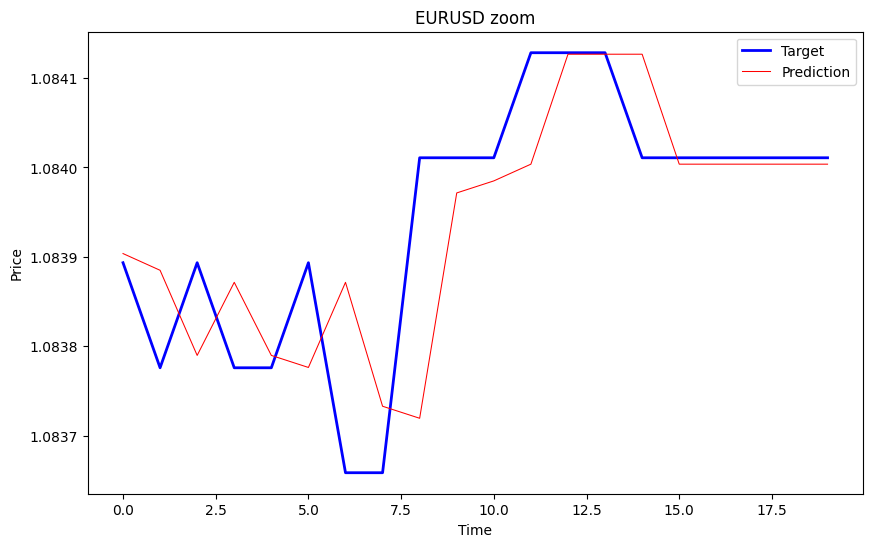

Mean Absolute Error: 0.00012851811023227005
Mean Squared Error: 3.53887795982232e-08
R-squared score: 0.9967376973747202


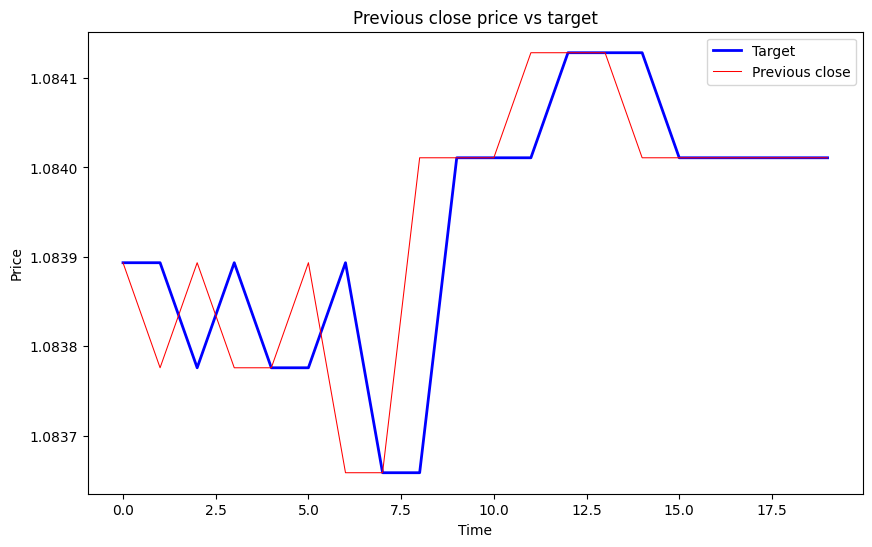

Mean Absolute Error: 0.00011801369795643082
Mean Squared Error: 3.3275104034426435e-08
R-squared score: 0.9969311688484017


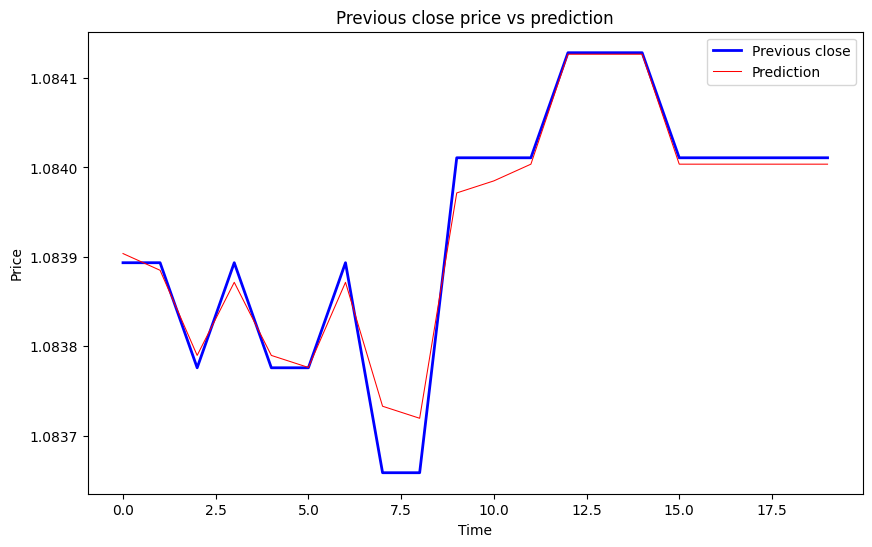

Mean Absolute Error: 3.6380890327430894e-05
Mean Squared Error: 2.702403747538961e-09
R-squared score: 0.999750767997718


In [3]:
ticker_name = 'EURUSD'
interval='5m'
space = {
    'max_depth': (1, 10, 1),
    'learning_rate': (0.01, 0.3, 0.01),
    'n_estimators': (100, 2000, 10),
    'window_size': (5, 200, 5)
}

if os.path.exists(f'{ticker_name}_{interval}.pickle'):
    data_dict = load_data_dict(ticker_name, interval, space['window_size'])
else:
    data_dict = create_data_dict(ticker_name, interval, space['window_size'])

learner = GeneticLearner(num_rounds=10, num_creatures=20, preserve_num=8, mutable_params=mutable_params, objective_func=objective_function, param_space=space, selection_func=roulette_selection)
best = learner.learn(data_dict)


if best is None:    # exit if there is no model to retrain
    print('Training has failed')
    sys.exit()

# retrain the model using best params from search
xgbreg_params = {
        'objective': 'reg:squarederror',
        'max_depth': best.params['max_depth'],
        'learning_rate': best.params['learning_rate'],
        'n_estimators': best.params['n_estimators']
    }
model = xgb.XGBRegressor(**xgbreg_params)
model.fit(data_dict[best.params['window_size']]['x_train'], data_dict[best.params['window_size']]['y_train'], verbose=False)
y_pred = model.predict(data_dict[best.params['window_size']]['x_test'])

# plot prediction and test data
create_plot(data_dict[best.params['window_size']]['y_test'], y_pred, 'EURUSD')
# create zoom plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data_dict[best.params['window_size']]['y_test'][-20:])), data_dict[best.params['window_size']]['y_test'][-20:], 'b', label="Target", linewidth=2)
plt.plot(np.arange(len(y_pred[-20:])), y_pred[-20:], 'r-', label="Prediction", linewidth=0.75)
plt.title(f"EURUSD zoom")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# calculate error values
mae = mean_absolute_error(data_dict[best.params['window_size']]['y_test'], y_pred)
mse = mean_squared_error(data_dict[best.params['window_size']]['y_test'], y_pred)
r2 = r2_score(data_dict[best.params['window_size']]['y_test'], y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared score:", r2)



# cena zamknięcia jako symulowany output modelu
prev_close = [x[-1] for x in data_dict[best.params['window_size']]['x_test']]

# plot ceny zamknięcia vs targetu (następna cena, to co chcemy przewidywać)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(prev_close[-20:])), prev_close[-20:], 'b', label="Target", linewidth=2)
plt.plot(np.arange(len(data_dict[best.params['window_size']]['y_test'][-20:])), data_dict[best.params['window_size']]['y_test'][-20:], 'r-', label="Previous close", linewidth=0.75)
plt.title(f"Previous close price vs target")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
# errory
mae = mean_absolute_error(prev_close, data_dict[best.params['window_size']]['y_test'])
mse = mean_squared_error(prev_close, data_dict[best.params['window_size']]['y_test'])
r2 = r2_score(prev_close, data_dict[best.params['window_size']]['y_test'])
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared score:", r2)


# plot cena zamknięcia vs faktyczna predykcja
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(prev_close[-20:])), prev_close[-20:], 'b', label="Previous close", linewidth=2)
plt.plot(np.arange(len(y_pred[-20:])), y_pred[-20:], 'r-', label="Prediction", linewidth=0.75)
plt.title(f"Previous close price vs prediction")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
# errory
mae = mean_absolute_error(prev_close, y_pred)
mse = mean_squared_error(prev_close, y_pred)
r2 = r2_score(prev_close, y_pred)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared score:", r2)